# Crank Nicholson 1D diffusion solver with variable conductivity

This doc is meant to provide a description of the Crank Nicholson finite difference routine I built with the intent of applying it to measured temperature data across our firn transect.

## Standard conduction equation

$$ \rho c_p \frac {\partial u}{\partial t} = \frac {\partial}{\partial x} \left(K\frac{\partial u}{\partial x}\right) + Q $$ 

where $\rho$ is firn density, $c_p$ is specific heat capacity (taken to be 2097 kg m-3), $K$ is spatially varying thermal conductivity, and $Q$ is an internal heat source with units of (W m-3).

## Numerical discretization
### Spatially varying conductivity
Variable thermal conductivity is accommodated by using the average value of the nodes within the outer first difference:
$$ K_+ = 0.5\left(K_{i+1} + K_{i} \right)$$
$$ K_- = 0.5\left(K_{i} + K_{i-1} \right)$$

The Crank Nicholson formulation of the standard conduction equation then becomes:
$$ \frac{\rho c_p}{\Delta t} \left( u_i^{n+1} - u_i^{n} \right) = \frac{\theta}{{\Delta x}^2} \left(K_+\left(u_{i+1}^n - u_i^n \right) - K_-\left(u_i^n-u_{i-1}^n\right) \right) + \frac{\left(1-\theta\right)}{{\Delta x}^2} \left(K_+\left(u_{i+1}^{n+1} - u_i^{n+1} \right) - K_-\left(u_i^{n+1}-u_{i-1}^{n+1}\right) \right) + Q$$

where $\theta=0.5$ for Crank Nicholson ($\theta=1$ for Forward Euler and $\theta=0$ for Backward Euler).

### Matrix representation
Letting $a=\frac{\Delta t}{\rho c_p}$,  
$$B u^{n+1} = A u^{n} +aQ$$

with:
$$ B= 
    \begin{bmatrix}
    1+\frac{a}{{\Delta x}^2}\left(K_+ + K_-\right) & -\frac{a}{{\Delta x}^2}K_+ & 0  & 0     \\
    -\frac{a}{{\Delta x}^2}K_- & 1+\frac{a}{{\Delta x}^2}\left(K_+ + K_-\right) & -\frac{a}{{\Delta x}^2}K_+ & 0 \\
    0 & -\frac{a}{{\Delta x}^2}K_- & 1+\frac{a}{{\Delta x}^2}\left(K_+ + K_-\right) & -\frac{a}{{\Delta x}^2}K_+ \\
    0 & 0 & -\frac{a}{{\Delta x}^2}K_- & 1+\frac{a}{{\Delta x}^2}\left(K_+ + K_-\right) 
    \end{bmatrix}$$
    
and 
$$ A=
    \begin{bmatrix}
    1-\frac{a}{{\Delta x}^2}\left(K_+ + K_-\right) & \frac{a}{{\Delta x}^2}K_+ & 0  & 0     \\
    \frac{a}{{\Delta x}^2}K_- & 1-\frac{a}{{\Delta x}^2}\left(K_+ + K_-\right) & \frac{a}{{\Delta x}^2}K_+ & 0 \\
    0 & \frac{a}{{\Delta x}^2}K_- & 1-\frac{a}{{\Delta x}^2}\left(K_+ + K_-\right) & \frac{a}{{\Delta x}^2}K_+ \\
    0 & 0 & \frac{a}{{\Delta x}^2}K_- & 1-\frac{a}{{\Delta x}^2}\left(K_+ + K_-\right) 
    \end{bmatrix}$$
        
### Solution
$$ u^{n+1} = B^{-1} \left[ A u^{n} +aQ \right]$$

## Implementation

In [2]:
# Dependencies
import numpy as np
from scipy import sparse 
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

class diff1D_CN():
    def __init__(self, dt, x, ubc, lbc):
        '''
        A Backward Euler solver for the 1-D diffusion equation with optional variable (in space)
        thermal conductivity.
                
        Inputs:
            dt  = Model time step
            x   = Model domain (solution nodes)
            ubc = 'Dirichlet' or 'Neumann' upper boundary type
            lbc = 'Dirichlet' or 'Neumann' lower boundary type
        '''
        # Model timing and spatial information
        self.dt = dt            # Time step
        self.dx = x[1]-x[0]     # Spatial step size
        self.nx = len(x)        # Number of nodes
        
        # Boundary types (Dirichlet or Neumann)
        self.ubc = ubc
        self.lbc = lbc         
        
    def build_matrix(self, k, rho, theta=0.5, cp=2097.):
        '''
        Build solver matrix
        theta = solver parameter (0.5 = Crank Nicholson, 0. = Backward Euler, 1.=Forward Euler)
        '''
        # Physical variables
        # ---------------------------------------------------------------------
        self.rho = rho
        self.cp = cp
        
        # If thermal conductivity is a scalar, convert it to an array of len 'nx'
        if isinstance(k, np.ndarray) == False:
            k = k * np.ones(self.nx)
        
        # Build average thermal diffusivity arrays -- this effectively accounts for
        # spatially varying thermal conductivity
        self.k = k
        k_mn = (k[0:-1]+k[1:])/2.
        k_p = np.hstack((k_mn, k[-1]))
        k_m = np.hstack((k[0], k_mn))
        self.a = self.dt/(self.rho*self.cp)
        
        # Build 'A' matrix -- Forward Euler
        # Diagonals
        a1 = theta * self.a / (self.dx**2) * k_mn
        a2 = theta * self.a / (self.dx**2) * (k_p+k_m)
        a3 = theta * self.a / (self.dx**2) * k_mn
        # Sparse matrix
        self.A = sparse.lil_matrix((self.nx, self.nx))
        self.A.setdiag(a1,k=1)
        self.A.setdiag(1-a2)
        self.A.setdiag(a3,k=-1)
        
        # Build 'B' matrix -- Backward Euler
        # ---------------------------------------------------------------------
        # Diagonals
        b1 = (1-theta) * self.a / (self.dx**2) * k_mn
        b2 = (1-theta) * self.a / (self.dx**2) * (k_p+k_m)
        b3 = (1-theta) * self.a / (self.dx**2) * k_mn
        # Sparse matrix
        self.B = sparse.lil_matrix((self.nx, self.nx))
        self.B.setdiag(-b1,k=1)
        self.B.setdiag(1+b2)
        self.B.setdiag(-b3,k=-1)
        
        # Set Boundary conditions
        # ---------------------------------------------------------------------
        #Upper (x=0)
        if self.ubc == 'Dirichlet':
            self.B[0,:] = np.zeros(self.nx)
            self.B[0,0] = 1.
            self.A[0,:] = np.zeros(self.nx)
            self.A[0,0] = 1.
        elif self.ubc == 'Neumann':
            self.B[0,1]   = -(1-theta) * self.a / (self.dx**2) * (k_p[0]+k[0])          
            self.A[0,1]   = theta * self.a / (self.dx**2) * (k_p[0]+k[0])
        # Lower (x=n)
        if self.lbc == 'Dirichlet':
            self.B[-1,:]  = np.zeros(self.nx)
            self.B[-1,-1] = 1.
            self.A[-1,:]  = np.zeros(self.nx)
            self.A[-1,-1] = 1.
        elif self.lbc == 'Neumann':
            self.B[-1,-2] = -(1-theta) * self.a / (self.dx**2) * (k_m[-1]+k[-1])     
            self.A[-1,-2] = theta * self.a / (self.dx**2) * (k_m[-1]+k[-1])
                        
        #Convert final 'B' matrix to compressed row format
        self.A = self.A.tocsr()
        self.B = self.B.tocsr()       
        
        
    def solve(self, u, Q, b_u=0, b_l=0):
        '''
        Solve for unew based on u and Q
        
        Inputs:
            u -- solution array at time 'n'
            Q -- Internal heat sources at time 'n' (W m-3)
            b_u -- upper boundary value (only applies for Neumann condition)
                    **Note this must be in units of W/m-2
            b_l -- lower boundary value (only applies for Neumann condition)
            
        Outputs:
            unew -- Solution 'u' at time n+1
        '''
        # Heat source
        # If Heat source is a scalar, convert it to an array of len 'nx'
        if isinstance(Q, np.ndarray) == False:
            Q = Q * np.ones(self.nx)
        gamma = Q*self.a # Heat source array 'gamma'
        
        # Adjust heat source gamma if Neumann boundary
        if self.ubc == 'Neumann':
            gamma[0] -= 2 * self.a / self.dx * b_u
        if self.lbc == 'Neumann':
            gamma[-1] -= 2 * self.a / self.dx * b_l 
        
        # Solve    
        u1 = np.asarray(np.dot(self.A.todense(),u))[0] + gamma
        unew = spsolve(self.B, u1)
            
        return unew
        

## Testing

### 1. Gaussian Pulse (scalar thermal conductivity)

The diffusion equation yields the following analytical solution for a Gaussian pulse:

$$u(x,t) = \frac{1}{\sqrt{4\pi\alpha t}} \exp \left( -\frac{\left(x-c\right)^2}{4\alpha t}\right)$$

At $t=0$ the solution yields a dirac delta, so I've replaced $t$ with $t=t+t_e$ to give the initial curve a finite width. As a test, using values similar for ice, compare the model with the analytical solution: 

In [9]:
#%% Set up timing, model domain, and physical variables
# Physical variables
k = 2.1      # Thermal conductivity (W m-1 K-1)  
rho = 900.  # Density (kg m**-3)
cp = 2097.  # Specific heat capacity of ice (J kg**-1 degC**-1)
Q = 0.      # Internal heat sources (W m-3)

# Spatial Domain
x0 = 0.
xf = 2.
dx = 0.005
x = np.arange(x0, xf+dx, dx)  # mesh points in space

# Time ( in seconds )
ndays = 0.25         # Number of days to run simulation
dt_min = 0.25        # time step in minutes
t0 = 0.
tf = ndays * 24.* 60.**2
dt = dt_min * 60.
t = np.arange(t0, tf+dt, dt)

#Model boundaries
ubc = 'Dirichlet'
lbc = 'Dirichlet'
u_ubc = 0.*np.ones(len(t))
u_lbc = 0.*np.ones(len(t))
Cu = 0. # Upper boundary heat flux for Neumann bc (if specified)
Cl = 0. # Lower boundary heat flux for Neumann bc (if specified)

# Analytical solution
def u_an(c, t, x, k, rho, cp):
    alpha = k/(rho*cp)
    u_t = 1./(4.*np.pi*alpha*t)**0.5 * np.exp(-1.*((x-c)**2)/(4.*alpha*t))
    return u_t

# Initial condition
te = 20.
u0 = u_an(1., t[0]+te, x, k, rho, cp)

# Calculate mesh Fourier number
F = k*dt/(rho*cp*dx**2)

#%% Instantiate diffusion solver
diff_cn = diff1D_CN(dt, x, ubc, lbc)
diff_cn.build_matrix(k, rho)

#%% Solve at each time
uCN_sol = [np.copy(u0)]
u_an_sol = [np.copy(u0)]
# Set initial condition
u_cn = np.copy(u0)
# solver loop
for i in range(1,len(t)):
    # Model
    unew_cn = diff_cn.solve(u_cn, 0., Cu, Cl)
    uCN_sol.append(unew_cn)
    u_cn = unew_cn    #update solution vector
    u_cn[0] = u_ubc[i]
    u_cn[-1] = u_lbc[i]
    
    # Analytical solution
    u_a = u_an(1., t[i]+te, x, k, rho, cp)
    u_an_sol.append(u_a)

an_sol = np.asarray(u_an_sol)
mod_sol = np.asarray(uCN_sol)

Results show good agreement for Fourier mesh numbers (~0.6) exceeding stability range for Forward Euler.

Text(0.5,1,'Maximum error v time')

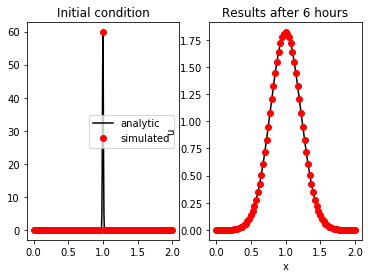

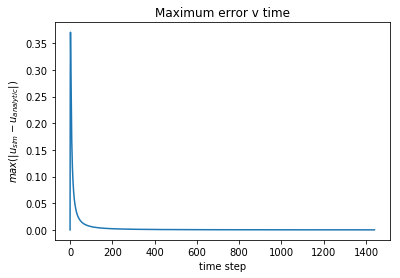

In [10]:
#%% Plot
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(121)
ax1.plot(x, u_an_sol[0], 'k-', label='analytic')
ax1.plot(x[::5],mod_sol[0,::5], 'ro', label='simulated')
ax1.legend()
ax1.set_title('Initial condition')

ax1a = fig1.add_subplot(122)
ax1a.plot(x, u_an_sol[-1], 'k-')
ax1a.plot(x[::5],mod_sol[-1,::5], 'ro')
ax1a.set_title('Results after 6 hours')
ax1a.set_xlabel('x')
ax1a.set_ylabel('u')

# maximum model/measure difference over time 
max_diff = np.max(abs(an_sol-mod_sol), axis=1)
fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111)
ax2.plot(max_diff)
ax2.set_xlabel('time step')
ax2.set_ylabel(r'$max(|u_{sim}-u_{analytic}|)$')
ax2.set_title('Maximum error v time')

### 2. Spatially variable conductivity

In the absence of internal heat sources, the conduction equation approaches a stationary limit as $t \to \infty$:

$$\frac {\partial}{\partial x} \left(K\frac{\partial T}{\partial x}\right) = 0 $$ 

With boundary conditions $T(0)=T_0 $ and $T(L)=T_L$, the exact solution to the above is:

$$ T(x)=T_0 + (T_L-T_0)\frac{\int\limits_0^x (K(\epsilon))^{-1}d\epsilon}{\int\limits_0^L (K(\epsilon))^{-1}d\epsilon} $$

As a test of the model formulation's treatment of spatially variable conductivity, let $K(x)=0.3x+0.1$. Then:
    $$ \int (K(\epsilon))^{-1}d\epsilon = \frac{1}{0.3}\ln \left( \frac{0.3\epsilon+0.1}{0.1} \right) $$

With this in hand, test to see if the modeled temperature approaches the exact solution from an initial condition:

Text(0,0.5,'u')

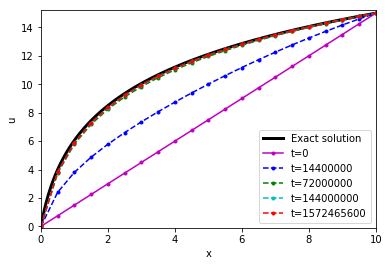

In [8]:
#%% Model timing, spatial dimension, and conductivity
# Time
dt = 14400. # Time step in seconds
wks = 50*52.
t_f = wks*7.*24.*60.**2
t = np.arange(0., t_f, dt) 
# Space
dx = 0.5
x = np.arange(0., 10.+dx, dx)
# Model physical parameters (density and thermal conductivity)
rho=900.
# Make thermal conductivity a linear function of x (values similar to firn)
k = 0.3*x+0.1

#%% Model boundaries
ubc = 'Dirichlet'
lbc = 'Dirichlet'
ubc_U = 0.
lbc_U = 15.

#%% Instantiate diffusion solver
diff_cn = diff1D_CN(dt, x, ubc, lbc)
diff_cn.build_matrix(k, rho)


#%% Solve at each time
u_sol = [] 
# Set initial condition
u0 = np.linspace(ubc_U, lbc_U, len(x))
u = u0
# solver loop
for i in range(len(t)):
    unew = diff_cn.solve(u, 0.)
    u_sol.append(unew)
    u = unew    #update solution vector
    u[0] = ubc_U
    u[-1] = lbc_U
    

#%% Analytical solution 
f_an = lambda x: (900.*2097./0.3 * np.log((0.3*x+0.1)/0.1))
x_sol = np.linspace(0., x[-1], 5000)
u_an = ubc_U+(lbc_U-ubc_U)*f_an(x_sol)/f_an(x_sol[-1])


#%% Plot
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111)
ax1.set_ylim(-0.1, 15.2)
ax1.set_xlim(0., 10.)
ax1.plot(x_sol, u_an, 'k-', lw=3, label='Exact solution')
ax1.plot(x, u0,'m.-', label='t=0')
ax1.plot(x, u_sol[1000], 'b.--', label='t='+str(int(t[1000])))
ax1.plot(x, u_sol[5000], 'g.--', label='t='+str(int(t[5000])))
ax1.plot(x, u_sol[10000], 'c.--', label='t='+str(int(t[10000])))
ax1.plot(x, u_sol[-1], 'r.--', label='t='+str(int(t[-1])))
ax1.legend()
ax1.set_xlabel('x')
ax1.set_ylabel('u')


Model approaches the exact solution, increasing confidence in the model implementation